# 線型結合GAN

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import csv
import numpy as np
import pandas as pd



In [18]:
parser = argparse.ArgumentParser()
#parser.add_argument('--dataset', required=True, help='cifar10 | lsun | mnist |imagenet | folder | lfw | fake')
#parser.add_argument('--dataroot', required=False, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=32, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=51, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.05, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--classes', default='bedroom', help='comma separated list of classes for the lsun data set')



opt = parser.parse_args(args=['--cuda'])
print(opt)


Namespace(batchSize=32, beta1=0.5, classes='bedroom', cuda=True, imageSize=64, lr=0.05, manualSeed=None, ndf=64, netD='', netG='', ngf=64, ngpu=1, niter=51, nz=100, outf='.', workers=2)


In [3]:
class MyDataset(Dataset):
    def __init__(self):
        data1 = np.loadtxt('data1.csv',delimiter="  ")
        data2 = np.loadtxt('data2.csv',delimiter="  ")
        dataframe = np.concatenate([data1,data2])
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self,idx):
        t = transforms.ToTensor()
        #label = self.dataframe[idx][0]
        data = torch.Tensor([self.dataframe[idx]])
        return data

dataset = MyDataset()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))


In [4]:
try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

_len = dataset.dataframe.shape[1]
print(_len)

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

Random Seed:  9992
59412


In [19]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(128,256,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,512,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,1024,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024,_len,bias=False)
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=59412, bias=False)
  )
)


In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(_len,512,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,256,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,1,bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)



netD = Discriminator(ngpu).to(device)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=59412, out_features=512, bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=False)
    (5): Sigmoid()
  )
)


[0/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[0

[5/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[5

[9/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[10/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 

[14/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[14/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[14/51][18/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[14/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[15/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.00

[19/51][15/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[19/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[19/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[19/51][18/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[19/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[20/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0

[24/51][12/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][13/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][14/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][15/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][18/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[24/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[25/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[25/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[25/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[25/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 

[29/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][12/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][13/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][14/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][15/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][18/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[29/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[30/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[30/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[30/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)):

[34/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][12/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][13/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][14/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][15/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][18/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[34/51][19/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z))

[39/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][12/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][13/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][14/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][15/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][16/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[39/51][17/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 

[44/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][12/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][13/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[44/51][14/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0

[49/51][0/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][1/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][2/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][3/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][4/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][5/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][6/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][7/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][8/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][9/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][10/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000 / 0.0000
[49/51][11/20] Loss_D: 27.6310 Loss_G: 27.6310 D(x): 0.0000 D(G(z)): 0.0000

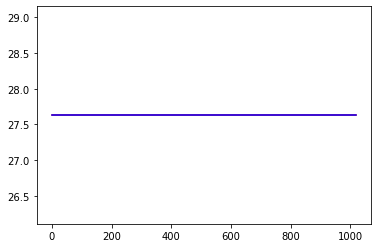

In [23]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, 1, 1, 128, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

Dlosses = []
Glosses = []

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        #print(real_cpu.size())
        #print(real_cpu[:,0,:])
        output = netD(real_cpu[:,0,:])
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(batch_size, 1, 1, 128, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        Dlosses.append(errD.item())
        Glosses.append(errG.item())
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    if epoch % 25 == 0:
        fake = netG(fixed_noise)
        result = fake[0][0].to('cpu').detach().numpy()
        resultfile = 'result_sample/result{}.csv'.format(epoch)
        with open(resultfile,'a') as f:
            np.savetxt(f,result,fmt='%.5f',delimiter=',')
        modeldatafile = 'modeldata_sample/{}sample.pth'.format(epoch)
        torch.save(netG.state_dict(),modeldatafile)
from matplotlib import pyplot as plt
plt.plot(Dlosses,color='red',label='Dlosses')
plt.plot(Glosses,color='blue',label='Glosses')
plt.show()